In [ ]:
# Make plots to visualize data collected by ChorusWaves search script
# Date created: not sure sorry :(
# Last modified: 7/20/2024
# Author: Max Feinland for Blum Research Group

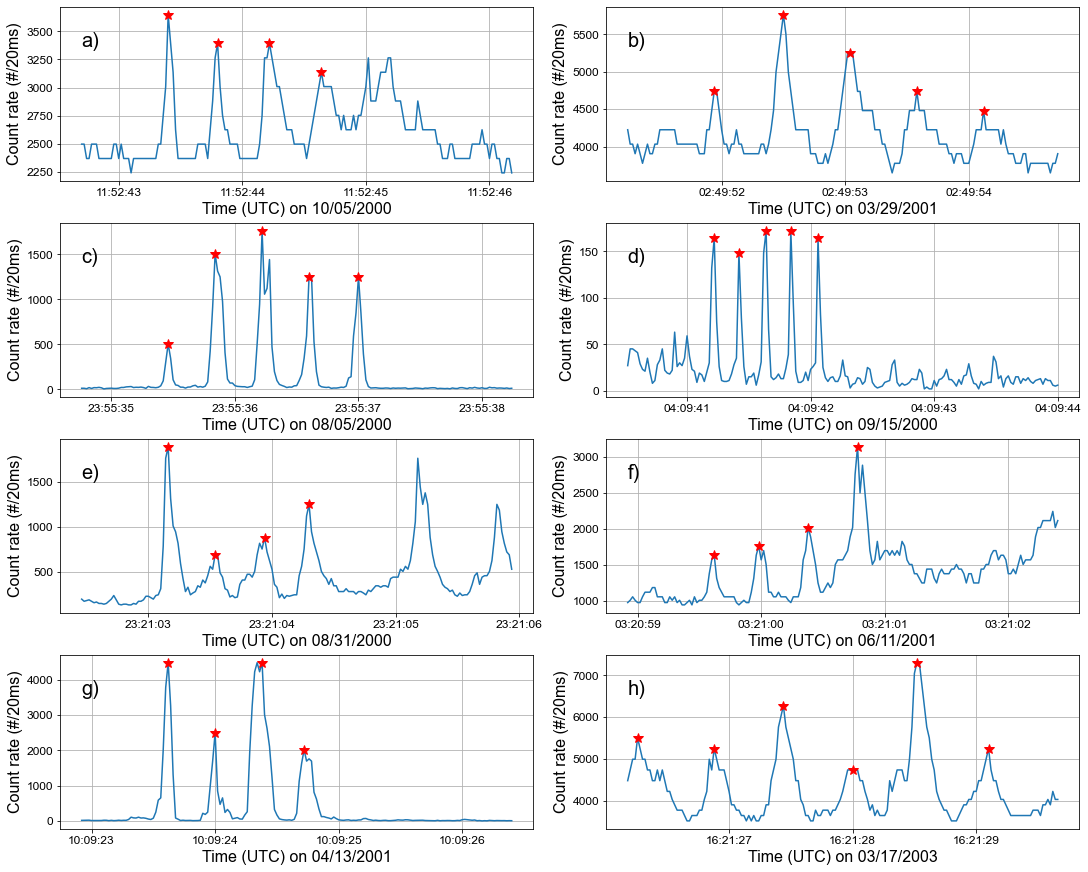

In [32]:
'''
Example event plots
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sampex # thanks to Mike Shumko for making this package
import matplotlib.dates as dates
from scipy.signal import find_peaks

plt.rcParams["font.family"] = "Arial" # bc I don't like the default Python font

def plot_date(ax, j):
    # Function that makes plots of events
    # Author: Max Feinland
    # Date created: not sure, sorry
    # Last modified: 7/23/2024
    
    # Inputs: axes object (which subplot to plot on), iterator variable, 
    # dictionary containing specifics for each plot
    
    # Outputs: none
    
    b1 = 25 # buffer between start time and start of plotting (in indices)
    b2 = 150 # buffer between stop time and end of plotting (in indices)
    t = plotting_data["t"][j] # timestamp of event start
    
    cur_t = pd.to_datetime(t) # convert text to DateTime
    h = sampex.HILT(cur_t) # request SAMPEX count rate data
    h.load()
    
    # find index of where SAMPEX data time matches timestamp
    m = np.where(h.times == cur_t)[0][0]
    d_plot = h.times[m-b1:m+b2]
    r_plot = h.counts[m-b1:m+b2]
    
    maxdis = max(r_plot) - min(r_plot) # range of interval
    # identify peaks in interval
    [pks, _] = find_peaks(r_plot, prominence=0.25*maxdis, distance=3)
    if j in [0, 4]:
        # The actual process of peaks found is a lot more finicky than this,
        # and can be found in the ChorusWaves search script. This version runs
        # a lot faster, albeit less accurately, so this line just fixes any discrepancy
        # between this method and the more robust way.
        pks = pks[0:4]
    elif j == 3:
        pks = pks[1:]
    
    # for plotting
    txt_loc_x = h.times[m-b1]
    txt_loc_y = 0.8*(max(r_plot) - min(r_plot)) + min(r_plot)
    xlbel = "Time (UTC) on " + cur_t.strftime('%m/%d/%Y')
    
    ax.plot(d_plot, r_plot)
    ax.plot(d_plot[pks], r_plot[pks], 'r*', markersize=10)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S')) 
    ax.set_xlabel(xlbel, fontsize=16)
    ax.grid()
    ax.set_ylabel("Count rate (#/20ms)", fontsize=16)
    ax.text(x=txt_loc_x, y=txt_loc_y, s=plotting_data["letter"][j], fontsize=20)
    ax.tick_params(labelsize=12)
    
# read in data
data = pd.read_csv("all_events_v2.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events only
good_data = good_data.reset_index(drop=True)

idx =  [15, 25, 10, 12, 11, 35, 33, 64] # indices of events I picked as examples
plotting_data = {"t": [good_data.t[x] for x in idx], 
                 "letter": ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']}

fig, ax = plt.subplots(4,2, figsize=(15,12), constrained_layout=True)
ax_flat = ax.flatten()

# iterate through axes object and plot each example event
for j, a in enumerate(ax_flat):
    plot_date(a, j)


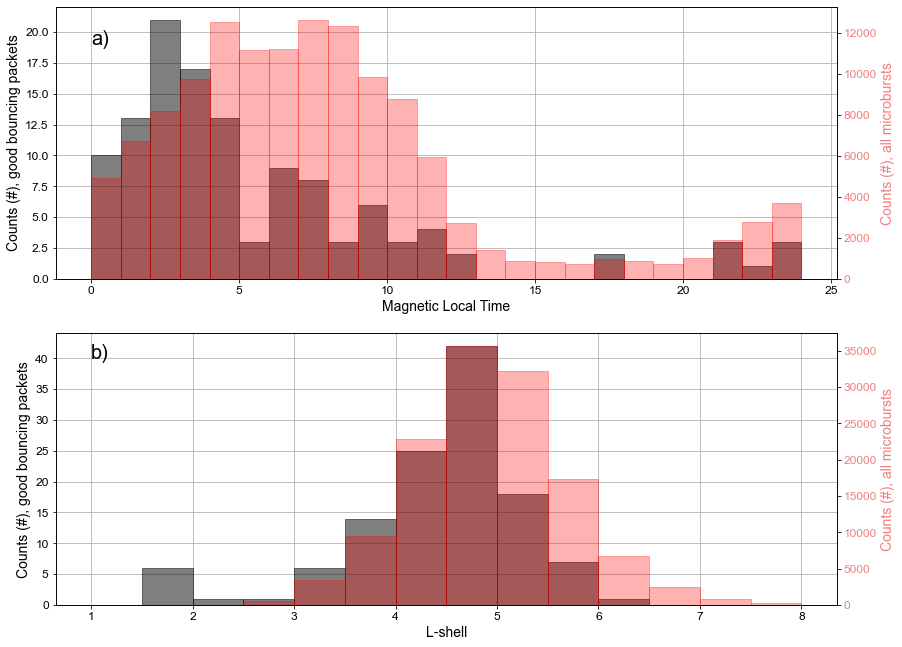

In [4]:
'''
MLT & L-shell histograms
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

plt.rcParams["font.family"] = "Arial"

# read in data
data = pd.read_csv("all_events_v2.csv") # my data
ref = pd.read_csv("microburst_catalog_00.txt", sep=",") # reference data

# limit reference data to time surveyed by my search script
time_needed = pd.to_datetime(ref['dateTime'])
idx = np.where((time_needed >= datetime(2000, 1, 1)) & (time_needed <= datetime(2003, 12, 31)))[0]
ref = ref.iloc[idx,:]

fig, ax = plt.subplots(2, 1, figsize=(14,11))
def make_hist(ax1, param, rmin, rmax, bin_num):
    # Function that makes histograms of variables of your choosing
    # Author: Max Feinland
    # Date created: 7/20/2024
    # Last modified: 7/20/2024
    
    # Inputs: axes object (which subplot to plot on), variable name, 
    # minimum range, maximum range, number of bins
    
    # Outputs: none
    
    ax2 = ax1.twinx() # make second axis for reference data
    
    # plot the events
    ax1.hist(data[param][data.final_eye<2], bins=bin_num, range=(rmin,rmax), alpha=0.5,
             label='good bouncing packets', facecolor='black', edgecolor='black', zorder=50)
    ax2.hist(ref[param], bins=bin_num, range=(rmin, rmax), alpha=0.3, label='all microbursts', 
             facecolor='red', edgecolor='red', zorder=20) # plot reference data
    
    # tick/label stuff (formatting)
    ax1.tick_params(labelsize=12)
    ax1.set_xlabel(param, fontsize=14)
    ax1.set_ylabel('Counts (#), good bouncing packets', fontsize=14)
    ax1.grid()
    
    ax2.set_ylabel('Counts (#), all microbursts', color="lightcoral", fontsize=14)
    ax2.tick_params(axis='y', labelcolor="lightcoral", labelsize=12)
    
    # adding subplot label
    if param=="MLT":
        ax1.text(0, 19, "a)", fontsize=20)
        ax1.set_xlabel("Magnetic Local Time", fontsize=14) # just because the variable is named
        # "MLT" in the datasets, but I wanted the x-axis label to be more descriptive
    else:
        ax1.text(1, 40, "b)", fontsize=20)
        ax1.set_xlabel("L-shell", fontsize=14) # just because the variable is named
        # "L" in the datasets, but I wanted the x-axis label to be more descriptive
        

# Call function for each variable
make_hist(ax[0], "MLT", 0, 24, 24)
make_hist(ax[1], "L", 1, 8, 14)

<ipython-input-25-eadb33c48fda>:132: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Text(0.05, 54, 'i)')

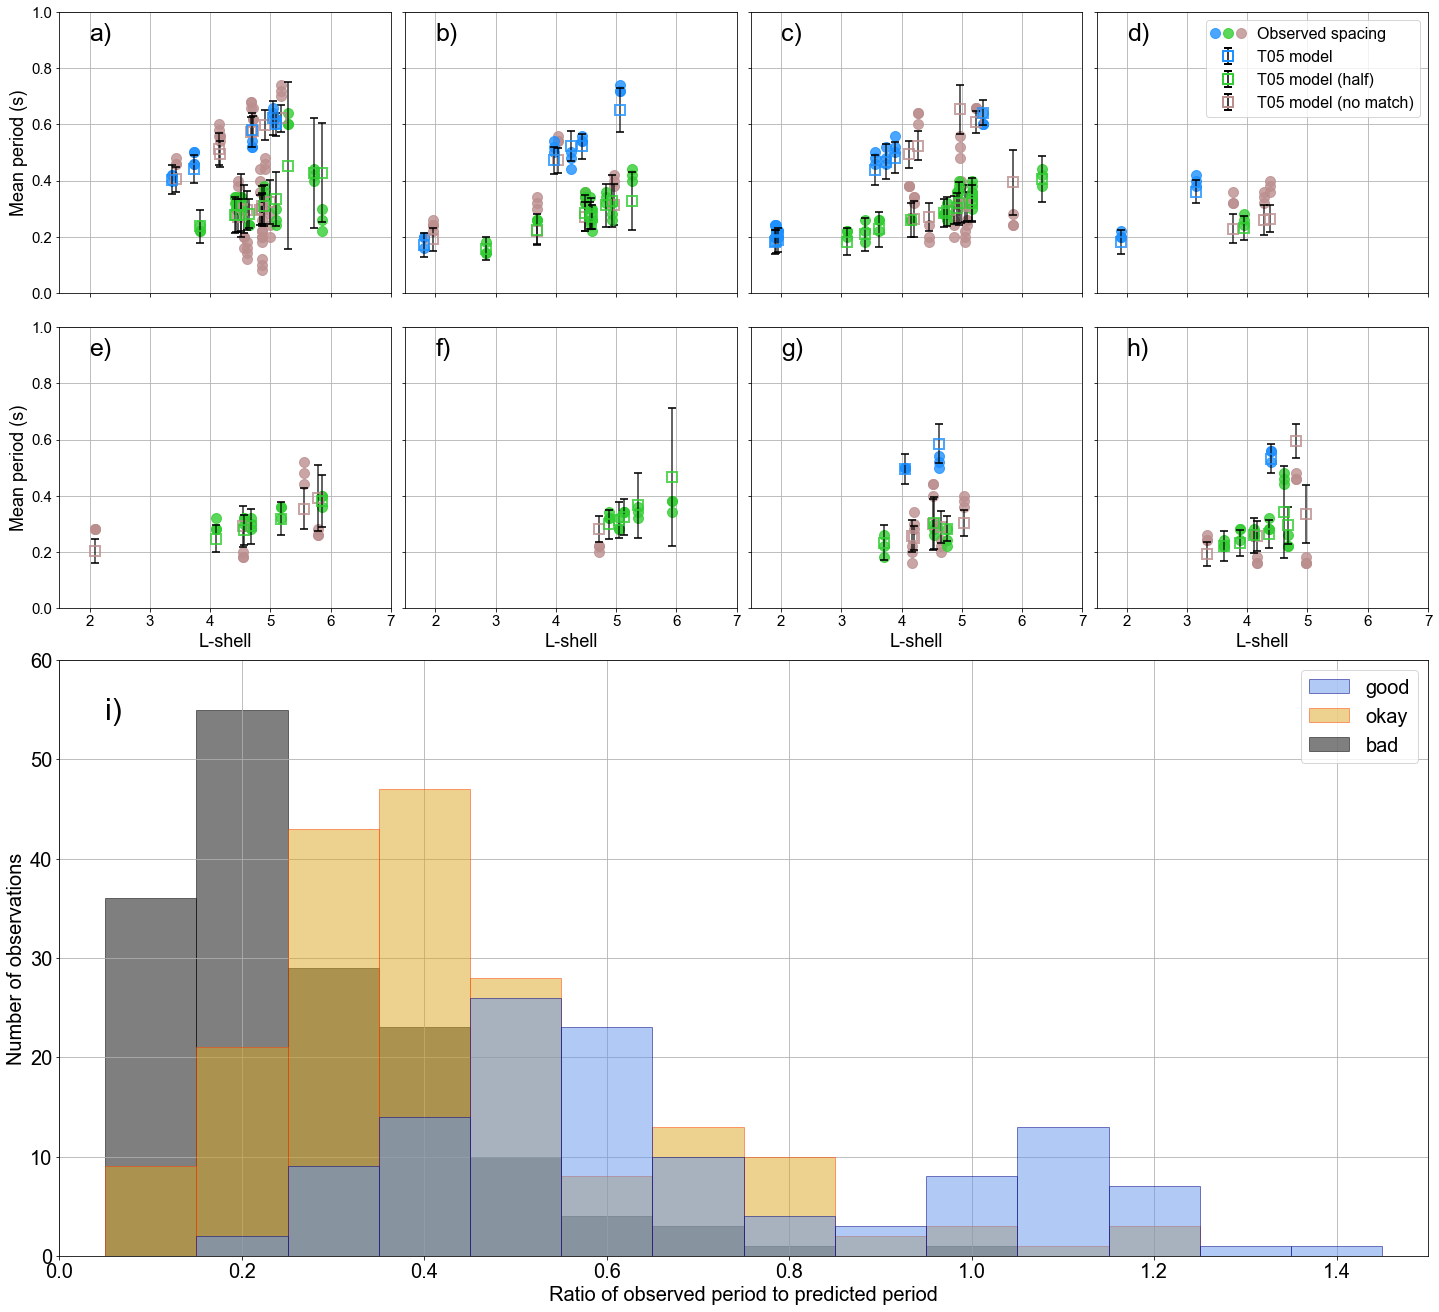

In [25]:
'''
Period vs. L-shell
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as dates
from matplotlib.legend_handler import HandlerTuple
import ast

plt.rcParams["font.family"] = "Arial"

def plot_specific_shape(ax, k):
    # Function that plots bounce period vs. L shell for a specific shape
    # Author: Max Feinland
    # Date created: sometime in July 2024
    # Last modified: 7/20/2024
    
    # Inputs: axes object (which subplot to plot on), iterator variable
    
    # Outputs: none
    
    current_shape = txt["shapes"][k] # pull stuff out of dict
    current_letter = txt["letter"][k]
    
    # find indices containing allowable shapes
    indices = np.where(good_data.shapes==current_shape)[0]

    fullper = np.zeros(len(good_data)) # initialize vector containing full/half classification
    
    for j in indices:
        err = np.sqrt(good_data.spread[j]**2 + 0.04**2) # propagate error
        if (abs(newper[j] - good_data.tb[j]) <= err) & \
        (abs(newper[j] - good_data.tb[j]/2) <= err):
            # Both conditions are true, so figure out which is closer
            if abs(newper[j] - good_data.tb[j]) <= abs(newper[j] - good_data.tb[j])/2:
                fullper[j] = 1
                edgecol = full_color
                tb = good_data.tb[j]
                zo = 10
            else:
                fullper[j] = 2
                edgecol = half_color
                tb = good_data.tb[j]/2
                zo = 10
        elif abs(newper[j] - good_data.tb[j]) <= err:
            fullper[j] = 1
            edgecol = full_color
            tb = good_data.tb[j]
            zo = 10
        elif abs(newper[j] - good_data.tb[j]/2) <= err:
            fullper[j] = 2
            edgecol = half_color
            tb = good_data.tb[j]/2
            zo = 10
        else:
            fullper[j] = 0
            edgecol = else_color
            zo = 5
            if abs(newper[j] - good_data.tb[j]) < abs(newper[j] - good_data.tb[j]/2):
                tb = good_data.tb[j]
            else:
                tb = good_data.tb[j]/2
        ax.plot(good_data.L[j]*np.ones(len(s.dt[j])), s.dt[j], 'o', color=edgecol, 
                alpha = 0.8, markersize=10, zorder=zo)
        ax.errorbar(good_data.L[j], tb, yerr=err, fmt='s', 
                 markerfacecolor='none', capsize=4, markeredgecolor=edgecol,
                 zorder=(zo+5), markersize=10, color='black', markeredgewidth=2, alpha=0.8)
    
    ax.text(2, 0.9, current_letter, fontsize=25) # subplot label
    ax.grid()
    
    if k in [4, 5, 6, 7]: # put xlabel on bottom 4 plots
        ax.set_xlabel("L-shell", fontsize=18)
    if k in [0, 4]: # put ylabel on leftmost 2 plots
        ax.set_ylabel("Mean period (s)", fontsize=18)
    ax.set_ylim(0, 1)
    ax.set_xlim(1.5, 7)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

# Import data
data = pd.read_csv("all_events_v2.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events
good_data = good_data.reset_index(drop=True) # reset index

# spread in model predictions
pers = pd.read_csv("model_pers.csv",index_col=0)
tb05 = pd.DataFrame({'tb05': good_data.tb})
pers = pers.join(tb05)
spread = pd.DataFrame({'spread': (pers.max(axis=1) - pers.min(axis=1))})
good_data = good_data.join(spread)

# spacings between peaks for each event
s = pd.read_csv("spacings.csv")
s['dt'] = s['dt'].apply(ast.literal_eval)
newper = [np.mean(x) for x in s.dt] # data.per is inaccurate, use this instead

# Making figures
fig = plt.figure(layout='constrained', figsize=(20,18))
subfigs = fig.subfigures(2, 1, wspace=0.07)

# First figure: bounce period vs. L for each shape
ax = subfigs[0].subplots(2, 4, sharex=True, sharey=True)
ax_flat = ax.flatten()

txt = {"shapes": ["decr", "blake", "crown", "flat", "incr", "half", "smile", "other"],
      "letter": ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]}

full_color = 'dodgerblue'
half_color = 'limegreen'
else_color = 'rosybrown'

# iterate through axes object and plot each shape type
for j, a in enumerate(ax_flat):
    plot_specific_shape(a, j)

p = ax[0,3]
p1, = p.plot(0, 0, 'o', color=full_color, alpha=0.8, markersize=10)
p2, = p.plot(0, 0, 'o', color=half_color, alpha=0.8, markersize=10)
p3, = p.plot(0, 0, 'o', color=else_color, alpha=0.8, markersize=10)
f = p.errorbar(0, 0, yerr=0.2, fmt='s', markeredgecolor=full_color, markerfacecolor='none',
               color='black', markersize=10, capsize=4, markeredgewidth=2)
h = p.errorbar(0, 0, yerr=0.2, fmt='s', markeredgecolor=half_color, markerfacecolor='none',
               color='black', markersize=10, capsize=4, markeredgewidth=2)
x = p.errorbar(0, 0, yerr=0.2, fmt='s', markeredgecolor=else_color, markerfacecolor='none',
               color='black', markersize=10, capsize=4, markeredgewidth=2)
l = p.legend([(p1, p2, p3), f, h, x], # i made the legend look nice
         ['Observed spacing', 'T05 model', 'T05 model (half)', 'T05 model (no match)'], 
         handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=16) 
fig.tight_layout()

## Second figure: bounce period histograms
ax2 = subfigs[1].subplots()

# Calculate period ratios for each type 
good_ratio = np.divide(newper, good_data.tb)
ok_ratio = np.divide(data.per[(data.final_eye>1.5) & (data.final_eye<3)], 
                     data.tb[(data.final_eye>1.5) & (data.final_eye<3)])
bad_ratio = np.divide(data.per[data.final_eye==3], data.tb[data.final_eye==3])

ax2.hist(good_ratio, bins=15, range=(-0.05,1.45), alpha=0.5, facecolor='cornflowerblue', edgecolor='navy',
        zorder=10, label='good') # good histogram
ax2.hist(ok_ratio, bins=15, range=(-0.05,1.45), alpha=0.5, facecolor='goldenrod', edgecolor='orangered', 
         zorder=5, label='okay') # ok histogram
ax2.hist(bad_ratio, bins=15, range=(-0.05,1.45), alpha=0.5, facecolor='black', edgecolor='black',
         zorder=0, label='bad') # bad histogram

# axis labels & ticks
ax2.set_xlabel("Ratio of observed period to predicted period", fontsize=20)
ax2.set_ylabel("Number of observations", fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.legend(fontsize=20)
ax2.grid()
ax2.set_xlim(0, 1.5)
ax2.set_ylim(0, 60)
ax2.text(0.05, 54, 'i)', fontsize=30) # subplot label

C:\Users\maxim\IRBEM-main\python\IRBEM\IRBEM.py:1120: RuntimeWarning: invalid value encountered in sqrt
  vparalel = lambda Ek, Bm, B, Erest = 511:c*beta(Ek, Erest)*np.sqrt(1 - np.abs(B/Bm))
C:\Users\maxim\IRBEM-main\python\IRBEM\IRBEM.py:1120: RuntimeWarning: invalid value encountered in sqrt
  vparalel = lambda Ek, Bm, B, Erest = 511:c*beta(Ek, Erest)*np.sqrt(1 - np.abs(B/Bm))
C:\Users\maxim\IRBEM-main\python\IRBEM\IRBEM.py:1120: RuntimeWarning: invalid value encountered in sqrt
  vparalel = lambda Ek, Bm, B, Erest = 511:c*beta(Ek, Erest)*np.sqrt(1 - np.abs(B/Bm))
C:\Users\maxim\IRBEM-main\python\IRBEM\IRBEM.py:1120: RuntimeWarning: invalid value encountered in sqrt
  vparalel = lambda Ek, Bm, B, Erest = 511:c*beta(Ek, Erest)*np.sqrt(1 - np.abs(B/Bm))
C:\Users\maxim\IRBEM-main\python\IRBEM\IRBEM.py:1120: RuntimeWarning: invalid value encountered in sqrt
  vparalel = lambda Ek, Bm, B, Erest = 511:c*beta(Ek, Erest)*np.sqrt(1 - np.abs(B/Bm))


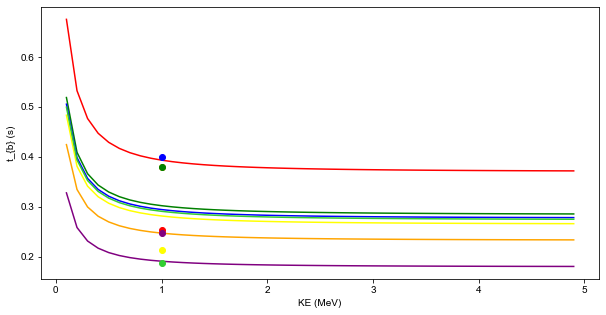

In [2]:
'''
See if failure events are more energetic electrons?
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import ast

def tsyganenko05(tstmp):
    
    # Author: Max Feinland, although Mike Shumko gets a lot of credit for the skeleton
    # Purpose: Calculates bounce period from T05 model.
    
    # If all of the preliminary conditions checked are true, the T05 model
    # will be called to check if the bounce period is within tolerance.
    
    # Also pulls attitude data. This saves some time, since you won't need to download
    # the attitude data otherwise.
    
    # Housekeeping
    import numpy as np
    import spacepy.datamodel
    from datetime import datetime
    import dateutil.parser
    from IRBEM import MagFields
    import sampex

    a = sampex.Attitude(tstmp) # attitude data (thanks Mike!)
    a.load()
    
    # change this for your needs. Of course, this pathing is for my machine.
    omniLoc = 'C:/Users/maxim/.spacepy/data/omnidata.h5'
    omniData = spacepy.datamodel.fromHDF5(omniLoc)
    omniT = np.array([dateutil.parser.parse(i.decode()) for i in omniData['UTC']])
    idx = np.where(tstmp >= omniT)[0][-1] # find relevant omni index
    T05Keys = ['Dst', 'Pdyn', 'ByIMF', 'BzIMF', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
    maginput05 = {}
    maginput = {}

    X = {}
    # find relevant attitude index
    a_idx = np.where(tstmp >= a['time'])[0][-1]
    
    # X is the time & location of the particle (lla)
    X['dateTime'] = tstmp.strftime('%Y-%m-%d %H:%M:%S.%f')
    X['x1'] = a['Altitude'][a_idx]
    X['x2'] = a['GEO_Lat'][a_idx]
    X['x3'] = a['GEO_Long'][a_idx]
    
    KE = np.arange(100, 5000, 100) # keV

    #T05 model
    model05 = MagFields(options = [0,0,0,0,0], kext = 11)
    for i in T05Keys:
        maginput05[i] = float(omniData[i][idx])
    Tb = model05.bounce_period(X, maginput05, KE) # call model
    return Tb

plt.rcParams["font.family"] = "Arial"

# Import data
data = pd.read_csv("all_events_v2.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events
good_data = good_data.reset_index(drop=True) # reset index

# spread in model predictions
pers = pd.read_csv("model_pers.csv",index_col=0)
tb05 = pd.DataFrame({'tb05': good_data.tb})
pers = pers.join(tb05)
spread = pd.DataFrame({'spread': (pers.max(axis=1) - pers.min(axis=1))})
good_data = good_data.join(spread)

# spacings between peaks for each event
s = pd.read_csv("spacings.csv")
s['dt'] = s['dt'].apply(ast.literal_eval)
newper = [np.mean(x) for x in s.dt] # data.per is inaccurate, use this instead

fullper = np.zeros(len(good_data)) # initialize vector containing full/half classification

for j in range(len(fullper)):
    err = np.sqrt(good_data.spread[j]**2 + 0.04**2) # propagate error
    if (abs(newper[j] - good_data.tb[j]) <= err) & \
    (abs(newper[j] - good_data.tb[j]/2) <= err):
        # Both conditions are true, so figure out which is closer
        if abs(newper[j] - good_data.tb[j]) <= abs(newper[j] - good_data.tb[j])/2:
            fullper[j] = 1
        else:
            fullper[j] = 2
    elif abs(newper[j] - good_data.tb[j]) <= err:
        fullper[j] = 1
    elif abs(newper[j] - good_data.tb[j]/2) <= err:
        fullper[j] = 2
    else:
        fullper[j] = 0

it = range(20)
t = pd.to_datetime(good_data.t)
col = ["red", "yellow", "orange", "green", "blue", "purple", "limegreen", "cornflowerblue"]
colcounter = 0
fig, ax = plt.subplots(figsize=(10,5))

for k in it:
    # find instances where obs period is less than predicted
    if ((fullper[k] == 0) & (newper[k] < good_data.tb[k])):
        # call t05 model
        tb_arr = tsyganenko05(t[k])
        ax.plot(1, newper[k], 'o', color=col[colcounter])
        if abs(newper[k] - good_data.tb[k]) <= abs(newper[k] - good_data.tb[k])/2:
            ax.plot(np.arange(0.1, 5, 0.1), tb_arr, color=col[colcounter])
        else:
            ax.plot(np.arange(0.1, 5, 0.1), tb_arr/2, color=col[colcounter])
        ax.set_xlabel("KE (MeV)")
        ax.set_ylabel("t_{b} (s)")
        colcounter = colcounter + 1
# print(tb_arr, newper[k])
# print(good_data.iloc[k,:])

<ipython-input-21-ec6b52984b6e>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-21-ec6b52984b6e>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


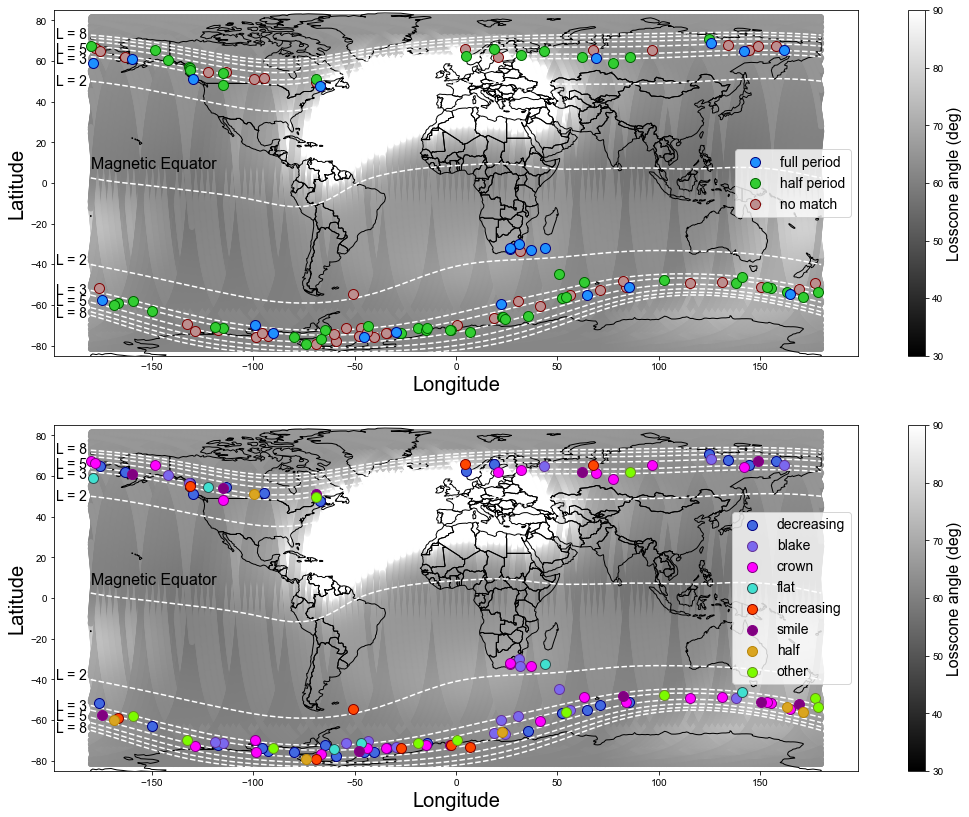

In [21]:
'''
Geographical location
'''

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import ast

plt.rcParams["font.family"] = "Arial" # because I don't like the default Python font

def make_losscone_map(ax):
    # Function that makes world and also L-shell contours
    # Author: Max Feinland
    # Date created: sometime in July 2024
    # Last modified: 7/20/2024
    
    # Inputs: axes object (which subplot to plot on)
    
    # Outputs: none

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='none', edgecolor='black', zorder=40)
    
    # read in SAMPEX attitude data. If you don't have this file you can download it from [LINK]
    # Make sure to change the pathing so it works with your machine.
    att = pd.read_csv('C:/Users/maxim/sampex-data/Attitude/PSSet_6sec_2000022_2000048.txt', 
                     sep=' ', header=60, on_bad_lines='skip')

    cols = np.array([7, 8, 35]) # take out lat, lon, losscone 2
    att = att.iloc[:150000, cols] # don't need the whole thing, just about 14 days for full coverage
    att.columns = ['lon', 'lat', 'losscone']

    # change longitude to be -180 to 180
    long_idx = np.where(att.lon > 180)[0]
    att.lon[long_idx] = att.lon[long_idx] - 360

    sc = ax.scatter(att.lon, att.lat, c=att.losscone, s=25, vmin=30, vmax=90, zorder=5, cmap='gray')
    c = plt.colorbar(sc)
    c.set_label("Losscone angle (deg)", fontsize=16)

    lgrid = pd.read_csv('Lgrid.dat', delimiter='\t', header=None)

    for i in np.arange(1, 30, 2):
        min_pos = np.argmin(lgrid.iloc[:,i])
        latl = np.concatenate(([lgrid.iloc[min_pos:,i-1], lgrid.iloc[:min_pos,i-1]]))
        lonl = np.concatenate(([lgrid.iloc[min_pos:,i], lgrid.iloc[:min_pos,i]]))
        ax.plot(lonl, latl, '--', color="white", zorder=45)

    ax.text(-180, 7, "Magnetic Equator", fontsize=16, zorder=50)
    ax.text(-197, 48, "L = 2", fontsize=14, zorder=50)
    ax.text(-197, -40, "L = 2", fontsize=14, zorder=50)
    ax.text(-197, 59, "L = 3", fontsize=14, zorder=50)
    ax.text(-197, -55, "L = 3", fontsize=14, zorder=50)
    ax.text(-197, 64, "L = 5", fontsize=14, zorder=50)
    ax.text(-197, -60, "L = 5", fontsize=14, zorder=50)
    ax.text(-197, 71, "L = 8", fontsize=14, zorder=50)
    ax.text(-197, -66, "L = 8", fontsize=14, zorder=50)
    
    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Latitude", fontsize=20)
    ax.set_ylim(-85, 85)
    return ax

data = pd.read_csv("all_events_v2.csv", index_col=0) # read in data
good_data = data[data.final_eye<2] # restrict to good events only
good_data = good_data.reset_index(drop=True) # drop index so it goes in order

# spread in model predictions
pers = pd.read_csv("model_pers.csv",index_col=0)
tb05 = pd.DataFrame({'tb05': good_data.tb})
pers = pers.join(tb05)
spread = pd.DataFrame({'spread': (pers.max(axis=1) - pers.min(axis=1))})

s = pd.read_csv("spacings.csv") # spacings between peaks for each event
s['dt'] = s['dt'].apply(ast.literal_eval)
newper = [np.mean(x) for x in s.dt] # calculate new mean spacing
newp = pd.DataFrame({'newper': newper})

good_data = good_data.join([spread, newp]) # add to good_data df

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(18, 14))

# call losscone map function
ax1 = make_losscone_map(ax1)
ax2 = make_losscone_map(ax2)

fullper = np.zeros(len(good_data)) # initialize vector containing full/half classification

# create full/half classification
# this is kept dynamic so you can change the error condition if you need to
for j in range(len(good_data.tb)):
    err = np.sqrt(spread.iloc[j,0]**2 + 0.04**2) # propagate error
    if (abs(good_data.newper[j] - good_data.tb[j]) <= err) & \
    (abs(good_data.newper[j] - good_data.tb[j]/2) <= err):
        # Both conditions are true, so figure out which is closer
        if abs(good_data.newper[j] - good_data.tb[j]) <= abs(good_data.newper[j] - good_data.tb[j])/2:
            fullper[j] = 1
        else:
            fullper[j] = 2
    elif abs(good_data.newper[j] - good_data.tb[j]) <= err:
        fullper[j] = 1
    elif abs(good_data.newper[j] - good_data.tb[j]/2) <= err:
        fullper[j] = 2
    else:
        fullper[j] = 0

# subplot 1: half/full/fail
full = ax1.scatter(good_data.lon[fullper==1], good_data.lat[fullper==1], 
                  s=100,  c='dodgerblue', label='full period', zorder=55, edgecolor='navy')
half = ax1.scatter(good_data.lon[fullper==2], good_data.lat[fullper==2], 
                  s=100,  c='limegreen', label='half period', zorder=50, edgecolor='darkgreen')
fail = ax1.scatter(good_data.lon[fullper==0], good_data.lat[fullper==0], 
                  s=100,  c='rosybrown', label='no match', zorder=45, edgecolor='maroon')
ax1.legend(loc='right', fontsize=14).set_zorder(50)

# subplot 2: shapes
decr = ax2.scatter(good_data.lon[good_data.shapes=="decr"], good_data.lat[good_data.shapes=="decr"], 
                  s=100,  c='royalblue', label='decreasing', zorder=50, edgecolor='navy')
blake = ax2.scatter(good_data.lon[good_data.shapes=="blake"], good_data.lat[good_data.shapes=="blake"],
                   s=100, c='mediumslateblue',  label='blake', zorder=50, edgecolor='rebeccapurple')
crown = ax2.scatter(good_data.lon[good_data.shapes=="crown"], good_data.lat[good_data.shapes=="crown"],
                   s=100, c='fuchsia', label='crown', zorder=50, edgecolor='purple')
flat = ax2.scatter(good_data.lon[good_data.shapes=="flat"], good_data.lat[good_data.shapes=="flat"],
                   s=100, c='turquoise', label='flat', zorder=50, edgecolor='darkslategray')
incr = ax2.scatter(good_data.lon[good_data.shapes=="incr"], good_data.lat[good_data.shapes=="incr"],
                   s=100, c='orangered', label='increasing', zorder=50, edgecolor='maroon')
smile = ax2.scatter(good_data.lon[good_data.shapes=="smile"], good_data.lat[good_data.shapes=="smile"],
                   s=100, c='purple', label='smile', zorder=50, edgecolor='darkmagenta')
half = ax2.scatter(good_data.lon[good_data.shapes=="half"], good_data.lat[good_data.shapes=="half"],
                   s=100, c='goldenrod', label='half', zorder=50, edgecolor='darkgoldenrod')
other = ax2.scatter(good_data.lon[good_data.shapes=="other"], good_data.lat[good_data.shapes=="other"],
                   s=100, c='lawngreen', label='other', zorder=50, edgecolor='olivedrab')

ax2.legend(loc='right', fontsize=14).set_zorder(50)